<a href="https://colab.research.google.com/github/suneelkumarpentela/Normalizer-free-models/blob/master/NF_oversampling_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_fscore_support

In [3]:
os.getcwd()

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Mathlogic")

In [16]:
train = pd.read_csv("./Data/train.csv")
train_target_new = np.where(train['target']==0,0,1)
train['target'] = train_target_new
print(train.shape)

(90000, 95)


In [20]:
val = pd.read_csv("./Data/valid.csv")
val_target_new = np.where(val['target']==0,0,1)
val['target'] = val_target_new
print(val.shape)

(29000, 95)


In [21]:
test = pd.read_csv("./Data/test.csv")
test_target_new = np.where(test['target']==0,0,1)
test['target'] = test_target_new
print(test.shape)

(29580, 95)


In [22]:
frames = [train,test]
X = pd.concat(frames)

In [24]:
# Class count
count_class_0, count_class_1 = X.target.value_counts()

# Divide by class
df_class_0 = X[X['target'] == 0]
df_class_1 = X[X['target'] == 1]

print(count_class_0, count_class_1)

113300 6280


In [35]:
df_class_1_over  = df_class_1.sample(count_class_0,replace=True)

In [36]:
X = pd.concat([df_class_0,df_class_1_over])

In [37]:
X_train = X.drop("target",axis=1)
X_test = val.drop("target",axis=1)
print(X_train.shape,X_test.shape)

(226600, 94) (29000, 94)


In [38]:
y_train = np.array([X['target']]).reshape(-1,1)
y_test = np.array([val['target']]).reshape(-1,1)
print(y_train.shape,y_test.shape)

(226600, 1) (29000, 1)


In [39]:
from collections import Counter

In [40]:
Counter(y_test.flatten())

Counter({0: 27488, 1: 1512})

In [41]:
Counter(y_train.flatten())

Counter({0: 113300, 1: 113300})

In [42]:
6280/(6280+113300)

0.05251714333500585

In [43]:
y_test.shape

(29000, 1)

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_np = scaler.transform(X_train)

X_test_np = scaler.transform(X_test)

In [45]:
y_train_np = y_train
y_test_np = y_test

In [46]:
X_train = torch.FloatTensor(X_train_np)

X_test = torch.FloatTensor(X_test_np)

y_train = torch.FloatTensor(y_train_np)
y_test = torch.FloatTensor(y_test_np)

In [47]:
print(y_train.shape)

torch.Size([226600, 1])


In [48]:
X_train_np.shape

(226600, 94)

In [49]:
X_test_np.shape

(29000, 94)

In [50]:
batch_size = 64
num_train_batches = int(X_train_np.shape[0]/batch_size)+1
num_test_batches = int(X_test_np.shape[0]/batch_size)+1
train_data_size = X_train_np.shape[0]
test_data_size = X_test_np.shape[0]
print("Train :",num_train_batches,train_data_size)
print("Test :",num_test_batches,test_data_size)

Train : 3541 226600
Test : 454 29000


In [51]:
train_dataset = TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [52]:
test_dataset = TensorDataset(X_test,y_test)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [53]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

In [54]:
# dataiter = iter(train_dataloader)
# images, labels = dataiter.next()
# print(type(images))
# print(images.shape)
# print(labels.shape)

In [67]:
class WSLinear(nn.Linear):

    def __init__(self, in_channels, out_channels,bias=True):
        super().__init__(in_channels, out_channels,bias=bias)

        nn.init.kaiming_normal_(self.weight)
        self.gain = nn.Parameter(torch.ones(
            self.weight.size()[0], requires_grad=True))

    def standardize_weight(self, eps):
        mean = torch.mean(self.weight, dim=(1), keepdims=True)
        var = torch.std(self.weight, dim=(1), keepdims=True, unbiased=False) ** 2
        fan_in = torch.prod(torch.tensor(self.weight.shape))

        scale = torch.rsqrt(torch.max(
            var * fan_in, torch.tensor(eps))) * self.gain.view_as(var)
        shift = mean * scale
        return self.weight * scale - shift

    def forward(self, input, eps=1e-4):
        weight = self.standardize_weight(eps)
        return F.linear(input, weight, self.bias)

In [68]:
class nf_block(nn.Module):

  def __init__(self,in_units,out_units,alpha,beta):
    super().__init__()

    self.nn = WSLinear(in_units,out_units)
    self.relu = nn.ReLU()

    self.alpha = alpha
    self.beta = beta
    self.skip_gain = nn.Parameter(torch.zeros(()))

  def forward(self,input):

    shortcut = input

    x = input*self.beta
    x = self.nn(x)
    out = shortcut + x*self.alpha*self.skip_gain

    out = self.relu(out)

    return out

In [77]:
class feedforward_nfnet(nn.Module):

  def __init__(self,layers = [94,64,64,64,64,64,64,1],alpha=0.2,beta=1.0):
    super().__init__()

    self.layers = layers
    self.layers = [94,64,64,64,64,64,64,64,64,64,64,1]
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.alpha = alpha #rate of change of variance at res bock
    self.expected_std = 1.0
    self.beta = 1.0

    self.first_nn = WSLinear(self.layers[0],self.layers[1])

    blocks = []

    for i in range(len(self.layers)-3):
      self.beta = 1/(self.expected_std)
      blocks.append(nf_block(self.layers[i+1],self.layers[i+2],self.alpha,self.beta))
      self.expected_std = (self.expected_std **2 + self.alpha**2)**0.5

    self.body = nn.Sequential(*blocks)

    self.last_nn = WSLinear(self.layers[-2],self.layers[-1])

  def forward(self,input):

    x = self.first_nn(input)
    x = self.relu(x)

    x = self.body(x)

    out = self.last_nn(x)
    out = self.sigmoid(out)

    return out

In [78]:
model = feedforward_nfnet()

In [79]:
total_params = sum(p.numel() for p in model.parameters())
total_params

44235

In [80]:
print(model.forward)

<bound method feedforward_nfnet.forward of feedforward_nfnet(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (first_nn): WSLinear(in_features=94, out_features=64, bias=True)
  (body): Sequential(
    (0): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (1): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (2): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (3): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (4): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (5): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (6): nf_block(
      (nn): WSLinear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
    (7): nf_block(
      (nn): W

In [81]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Mathlogic/nfnets_pytorch'

In [82]:
if(os.getcwd() != r"/content/drive/My Drive/Colab Notebooks/Mathlogic/nfnets_pytorch"):
  os.chdir(r"./nfnets_pytorch")

In [83]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Mathlogic/nfnets_pytorch'

In [84]:
from nfnets import SGD_AGC

In [85]:
# loss_func = nn.BCELoss(reduction="sum")
# optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
loss_func = nn.BCELoss()
optimizer = SGD_AGC(
        named_params=model.named_parameters(), # Pass named parameters
        lr=1e-3,
        momentum=0.9,
        clipping=0.1, # New clipping parameter
        weight_decay=2e-5, 
        nesterov=True)

In [86]:
X_train_np.shape

(226600, 94)

In [87]:
epochs = 100

In [88]:
losses = []
accuracy = []
val_losses = []
val_accuracy = []

for epoch in range(epochs):

  model.train()
  running_loss = 0
  running_val_loss = 0
  running_acc = 0
  running_val_acc = 0

  for i,data in enumerate(train_dataloader):
    train_x,train_y = data
    y_pred = model(train_x)
    loss = loss_func(y_pred,train_y)
    # predicted = model(torch.tensor(X_train_np,dtype=torch.float32))
    acc = (y_pred.reshape(-1).detach().numpy().round() == 
           train_y.reshape(-1).detach().numpy().round()).mean()
    running_loss += loss.item()/(num_train_batches)
    running_acc += acc/(num_train_batches)
    
    #reset grads
    optimizer.zero_grad()
    
    #backward
    loss.backward()

    #weight updates
    optimizer.step()

  print(f'Epoch: {epoch+1} Loss: {running_loss} Accuracy: {running_acc}',end = " ")

  model.eval()  
  for i,data in enumerate(test_dataloader):
    X_val,y_val = data
    y_pred_val = model(X_val)
    val_loss = loss_func(y_pred_val,y_val)
    val_acc = (y_pred_val.reshape(-1).detach().numpy().round() == 
           y_val.reshape(-1).detach().numpy().round()).mean()

    running_val_loss += val_loss.item()/(num_test_batches)
    running_val_acc += val_acc/(num_test_batches)
    
  print(f'Val Loss: {running_val_loss} Val Accuracy: {running_val_acc}')


  losses.append(running_loss)
  accuracy.append(running_acc)
  val_losses.append(running_val_loss)
  val_accuracy.append(running_val_acc)  

Epoch: 1 Loss: 0.6712793281979884 Accuracy: 0.6180757554363016 Val Loss: 0.6489857364331044 Val Accuracy: 0.5999449339207047
Epoch: 2 Loss: 0.6259798586065558 Accuracy: 0.6638996752329676 Val Loss: 0.6070688716115415 Val Accuracy: 0.6234856828193841
Epoch: 3 Loss: 0.6047550748967405 Accuracy: 0.6762134637107985 Val Loss: 0.6063813681381908 Val Accuracy: 0.6170498348017626
Epoch: 4 Loss: 0.5959887092260279 Accuracy: 0.6813920855690334 Val Loss: 0.6006252719048357 Val Accuracy: 0.6209732929515432
Epoch: 5 Loss: 0.5916507051543831 Accuracy: 0.6851622070036532 Val Loss: 0.602430104815488 Val Accuracy: 0.6231415198237885
Epoch: 6 Loss: 0.5889857617248702 Accuracy: 0.687146992375018 Val Loss: 0.5970056744267763 Val Accuracy: 0.6265143171806182
Epoch: 7 Loss: 0.5870053879338041 Accuracy: 0.6886022663089326 Val Loss: 0.5942477520210632 Val Accuracy: 0.6297494493392085
Epoch: 8 Loss: 0.5853671730574627 Accuracy: 0.6901087263484732 Val Loss: 0.5927320267791794 Val Accuracy: 0.6299559471365654
Ep

Text(0, 0.5, 'loss')

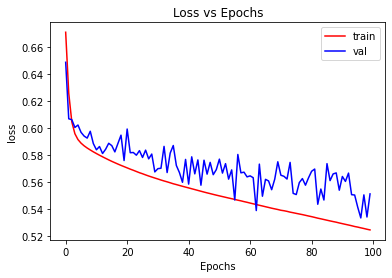

In [89]:
plt.plot(losses,'r',label='train')
plt.plot(val_losses,'b',label='val')
plt.legend()
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

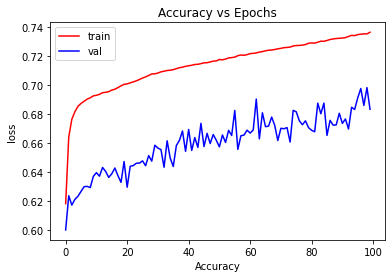

In [90]:
plt.plot(accuracy,'r',label='train')
plt.plot(val_accuracy,'b',label='val')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')

In [91]:
model.eval()
preds_train = []
with torch.no_grad():
   for i,data in enumerate(train_loader):
     trainx,trainy = data
     y_hat = model.forward(trainx)
     preds_train.append(y_hat)

In [92]:
preds_train = np.array(preds_train)
preds_train

array([0.390394  , 0.02049743, 0.5286685 , ..., 0.7377672 , 0.20417993,
       0.42468458], dtype=float32)

In [93]:
def best_f1(preds,y_test_np):
  f1_max = 0
  cutoff = -1
  for i in np.arange(0.01,1,0.01):
    preds1 = (preds>=i)*1 
    #print(sum(preds1))
    f1_score = sklearn.metrics.precision_recall_fscore_support(preds1,y_test_np)[2][1]
    print(f1_score)
    if (not f1_score):
      break
    if (f1_score > f1_max):
      f1_max = f1_score
      cutoff = i
  return cutoff,f1_max

In [94]:
train_cutoff,train_f1 = best_f1(preds_train,y_train_np)

0.6686732766761095
0.6722619270124098
0.6766325774772407
0.6809344140956439
0.6856961066505075
0.6900505223079175
0.6942632516430194
0.6986399206027759
0.7026707376663959
0.7066559321343655
0.7105390905250948
0.7144560962767003
0.7181147412749952
0.7214270338348642
0.7246613044589119
0.7281368635755902
0.7310525936646605
0.7334526646822062
0.7360977049811098
0.7390610817448876
0.7412843543449698
0.7436379498069237
0.7456036158069029
0.7482623790513104
0.7505894031517558
0.7525359050856865
0.7543777546501638
0.7557957586263885
0.7573690526338146
0.7590132692136433
0.7596201468593209
0.7599960952046944
0.7616867662792306
0.7625392309271698
0.7628247293152507
0.7630959300159461
0.7634566862910008
0.7621515347811758
0.7617374164887258
0.7618816608143905
0.7615088744765165
0.7604620203602191
0.7602016843884122
0.7600829812734677
0.7572392035668871
0.7558462437883658
0.7544758604588293
0.7539232412023974
0.7518743663452673
0.7489667504512558
0.7455995634732864
0.7417103192567204
0.7394472000

In [95]:
train_cutoff,train_f1

(0.37, 0.7634566862910008)

In [96]:
preds_train_ideal = (preds_train>=train_cutoff)*1

In [97]:
print(classification_report(preds_train_ideal,y_train_np))

              precision    recall  f1-score   support

           0       0.55      0.84      0.66     73564
           1       0.90      0.66      0.76    153036

    accuracy                           0.72    226600
   macro avg       0.72      0.75      0.71    226600
weighted avg       0.78      0.72      0.73    226600



In [98]:
model.eval()
preds = []
with torch.no_grad():
   for i,data in enumerate(test_loader):
     test_x,test_y = data
     y_hat = model.forward(test_x)
     preds.append(y_hat)

In [99]:
np.array(preds)

array([0.03406788, 0.1822631 , 0.84227943, ..., 0.37760302, 0.71518785,
       0.75600237], dtype=float32)

In [100]:
preds = np.array(preds)
# preds[preds>=0.5] = 1
# preds[preds<=0.5] = 0


In [101]:
np.unique(preds)

array([3.8132821e-06, 8.7150893e-06, 4.2071879e-05, ..., 9.9256295e-01,
       9.9476200e-01, 9.9559033e-01], dtype=float32)

In [102]:
preds_dummy = (preds>=0.5)*1

In [103]:
sklearn.metrics.precision_recall_fscore_support(preds_dummy,y_test_np)

(array([0.68197031, 0.71031746]),
 array([0.97716847, 0.1094132 ]),
 array([0.80330819, 0.18961864]),
 array([19184,  9816]))

In [104]:
sklearn.metrics.precision_recall_fscore_support(preds_dummy,y_test_np)[2][1]

0.1896186440677966

In [105]:
np.arange(0.01,1,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [106]:
cutoff,f1_max = best_f1(preds,y_test_np)

0.0997918250008261
0.10106971597196608
0.10304273504273503
0.10480775940269345
0.10620097256238242
0.10824518185770178
0.11004024962150585
0.1119186593861796
0.1137000499021151
0.11539213768824565
0.1171498066111089
0.11900113876687815
0.12046396023198011
0.1221187476296827
0.12405498281786942
0.1261158760721162
0.1274907502340302
0.12948921679909192
0.13135514882603067
0.13320163679977423
0.13530736428537207
0.1367496339677892
0.13840727308857867
0.1402157945392837
0.1419874109998968
0.14367484114897863
0.14475722450723782
0.14602587800369687
0.1480374245695621
0.1501721899170101
0.1522550991094513
0.15387313650979245
0.15557280162378365
0.15753883643009442
0.1591643869684158
0.1609122584732341
0.164238067482676
0.16570710078750578
0.16797403299972952
0.16992200980053832
0.1730714891212207
0.17488789237668162
0.17583555161194914
0.17733393856861854
0.18001395457012173
0.18190468638490206
0.18382591750568367
0.18617865797610092
0.18793443748390973
0.1896186440677966
0.1924367461684955


In [107]:
print(cutoff,f1_max)

0.73 0.22585513078470826


In [108]:
preds_ideal = (preds>=cutoff)*1

In [109]:
print(classification_report(preds_ideal,y_test_np))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     26536
           1       0.30      0.18      0.23      2464

    accuracy                           0.89     29000
   macro avg       0.61      0.57      0.58     29000
weighted avg       0.87      0.89      0.88     29000

